In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os
import pickle

from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.central_complex import CX_SPIKING
from cx_spiking.constants import *
import cx_spiking 

In [3]:
routes_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/routes/')

experiments_path = os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/experiments/vonmises_vs_cosine/experiments/')

T_outbound = 1500
T_inbound = 1500

In [22]:
rs_vm = [[],[]]
rs_cos = [[],[]]

for cpu4_method in [1,2]:
    for exp in range(100):
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        h = data['h']
        v = data['v']
        cx_log = data['cx_log']

        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            data = pickle.load(fh)

        spiking_cx_vm = data['spiking_cx_vm']
        spiking_cx_cos = data['spiking_cx_cos']

#         plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,:8])
#         plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,8:])
#         plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][T_outbound,:])
#         plt.plot(cx_log.memory[:,T_outbound]*spiking_cx_vm['CPU4_memory_history'][T_outbound,:].max())
#         plt.show()
        
        s_vm = spiking_cx_vm['CPU4_memory_history'][T_outbound,:]
        s_cos = spiking_cx_cos['CPU4_memory_history'][T_outbound,:]
        s_t = cx_log.memory[:,T_outbound]
    
        rs_vm[cpu4_method-1].append(scipy.stats.pearsonr(s_vm,s_t)[0])
        rs_cos[cpu4_method-1].append(scipy.stats.pearsonr(s_cos,s_t)[0])

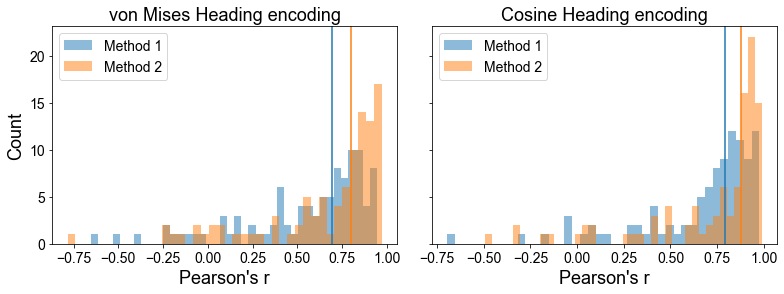

0.555579153779339 0.6614345112416413
0.6678039699337175 0.7257399149599878

0.6925022364419544 0.8025017452382432
0.7901854523236314 0.8781498087073486


In [51]:
fig, ax = plt.subplots(1,2, figsize=(13,4), sharey=True, gridspec_kw={'wspace': 0.1})



ax[0].hist(rs_vm[0], bins=40, alpha=0.5, color='tab:blue', label='Method 1')
ax[0].hist(rs_vm[1], bins=40, alpha=0.5, color='tab:orange', label='Method 2')
ax[0].axvline(np.median(rs_vm[0]), color='tab:blue')
ax[0].axvline(np.median(rs_vm[1]),  color='tab:orange')
# ax[0].axvline(np.mean(rs_vm[0]), ls='--', color='tab:blue')
# ax[0].axvline(np.mean(rs_vm[1]), ls='--', color='tab:orange')
ax[0].set_xlabel('Pearson\'s r', fontsize=18)
ax[0].set_ylabel('Count', fontsize=18)
ax[0].legend(loc='upper left')
ax[0].set_title('von Mises Heading encoding', fontsize=18)
# plt.show()

ax[1].hist(rs_cos[0], bins=40, alpha=0.5, color='tab:blue', label='Method 1')
ax[1].hist(rs_cos[1], bins=40, alpha=0.5, color='tab:orange', label='Method 2')
ax[1].axvline(np.median(rs_cos[0]), color='tab:blue')
ax[1].axvline(np.median(rs_cos[1]),  color='tab:orange')
# ax[1].axvline(np.mean(rs_cos[0]), ls='--', color='tab:blue')
# ax[1].axvline(np.mean(rs_cos[1]), ls='--', color='tab:orange')
ax[1].set_xlabel('Pearson\'s r', fontsize=18)

ax[1].legend()
ax[1].set_title('Cosine Heading encoding', fontsize=18)
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_memory_correlations.pdf'),
             bbox_inches='tight')

plt.show()

print(np.mean(rs_vm[0]), np.mean(rs_vm[1]))
print(np.mean(rs_cos[0]), np.mean(rs_cos[1]))
print()
print(np.median(rs_vm[0]), np.median(rs_vm[1]))
print(np.median(rs_cos[0]), np.median(rs_cos[1]))

In [187]:
def decode_cpu4(CPU4_memory):
    '''
    Shifts both CPU4 by +1 and -1 column to cancel 45 degree flow
    preference. When summed single sinusoid should point home.

    From Stone et al.
    '''
    cpu4_reshaped = CPU4_memory.reshape(2, -1)
    cpu4_shifted = np.vstack([np.roll(cpu4_reshaped[0], 1),
                              np.roll(cpu4_reshaped[1], -1)])
    return cpu4_shifted


def decode_position( cpu4_reshaped, cpu4_mem_gain=1):
    '''
    Decode position from sinusoid in to polar coordinates.
    Amplitude is distance, Angle is angle from nest outwards.
    Without offset angle gives the home vector.
    Input must have shape of (2, -1)

    From Stone et al.
    '''
    signal = np.sum(cpu4_reshaped, axis=0)
    fund_freq = np.fft.fft(signal)[1]
    angle = -np.angle(np.conj(fund_freq))
    distance = np.absolute(fund_freq) / cpu4_mem_gain
    return angle, distance

def decode_cpu4_state(CPU4_memory_history, bee_coords, step):
    tb1_angle = math.atan2(bee_coords[step-1,0], bee_coords[step-1,1])

    decoded_cpu4 = decode_cpu4(CPU4_memory_history[step-1,:])
    cpu4_angle, distance = decode_position(decoded_cpu4)
    cpu4_angle = make_angle(-cpu4_angle)

    return tb1_angle, cpu4_angle, distance

def make_angle( theta):
    '''
    Return an angle in [-pi,pi]
    from Stone et al.
    '''
    return (theta + np.pi) % (2.0 * np.pi) - np.pi

    
data = np.zeros((2, 100, 6))
distances = np.zeros((2, 100, 3))

for cpu4_method in [1,2]:
    for exp in range(100):
        with open(os.path.join(routes_path, f'route_{exp}.pickle'), 'rb') as fh:
            d = pickle.load(fh)

        h = d['h']
        v = d['v']
        cx_log = d['cx_log']
#         data[cpu4_method][exp]['h'] = h
#         data[cpu4_method][exp]['v'] = v
#         data[cpu4_method][exp]['cx_log'] = cx_log

        real_path = cx_spiking.plotting.compute_real_path(h)
        real_angle = math.atan2(real_path[T_outbound-1,0], real_path[T_outbound-1,1])

        xy = np.vstack([np.array([0.0, 0.0]), np.cumsum(v, axis=0)])
        
        with open(os.path.join(experiments_path, f'exp_{exp}_cpu4_{cpu4_method}.pickle'), 'rb') as fh:
            d = pickle.load(fh)

        spiking_cx_vm = d['spiking_cx_vm']
        spiking_cx_cos = d['spiking_cx_cos']

        
        tb1_angle_vm, cpu4_angle_vm, distance_vm = decode_cpu4_state(spiking_cx_vm['CPU4_memory_history'], spiking_cx_vm['bee_coords'], T_outbound)
#         print(np.rad2deg(real_angle), np.rad2deg(tb1_angle_vm), np.rad2deg(cpu4_angle_vm))
        tb1_angle_cos, cpu4_angle_cos, distance_cos = decode_cpu4_state(spiking_cx_cos['CPU4_memory_history'], spiking_cx_cos['bee_coords'], T_outbound)
#         print(np.rad2deg(real_angle), np.rad2deg(tb1_angle_cos), np.rad2deg(cpu4_angle_cos))

#         print()
#         cx_spiking.plotting.plot_bee_path(spiking_cx_vm['bee_coords'], T_outbound, T_inbound=False, figsize=(8,8))

        data[cpu4_method-1, exp,:] = [real_angle, decoded_real, tb1_angle_vm, cpu4_angle_vm, tb1_angle_cos, cpu4_angle_cos]
#         data[cpu4_method][exp]['spiking_cx_vm'] = spiking_cx_vm
#         data[cpu4_method][exp]['spiking_cx_cos'] = spiking_cx_cos

        real_distance = np.linalg.norm([0,0] - xy[T_outbound])

        distances[cpu4_method-1, exp,:] = [real_distance, distance_vm, distance_cos]
    
        # plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,:8])
        # plt.show()
        # plt.plot(spiking_cx_vm['CPU4_memory_history'][:T_outbound,8:])
        # plt.show()
#         plt.plot(spiking_cx_vm['CPU4_memory_history'][-1,:])
#         plt.plot(cx_log.memory[:,-1]*spiking_cx_vm['CPU4_memory_history'][T_outbound,:].max())
#         plt.show()



In [88]:
print(np.rad2deg(data[1,-1,:]))

[136.66596997 139.21063598 142.87160532 131.90307779 141.04191864]


In [89]:
method1 = data[0,:,:] 
method2 = data[1,:,:]

In [101]:
def plot_signed_diff(method):
    plt.hist(make_angle(method[:,0] - method[:,2]), label='vm', alpha=0.6)
    plt.hist(make_angle(method[:,0] - method[:,4]), label='cos', alpha=0.6)
    plt.legend()
    plt.plot()

In [102]:
plot_signed_diff(method1)
plt.show()
plot_signed_diff(method2)

TypeError: boxplot() got an unexpected keyword argument 'label'

[]

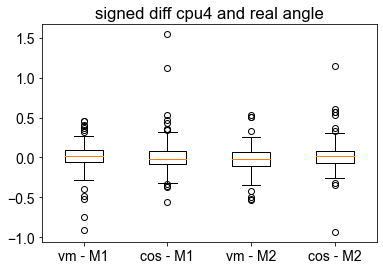

In [112]:
d = [make_angle(method1[:,0] - method1[:,2]), make_angle(method1[:,0] - method1[:,4])]
d += [make_angle(method2[:,0] - method2[:,2]), make_angle(method2[:,0] - method2[:,4])]
labels = ['vm - M1', 'cos - M1', 'vm - M2', 'cos - M2']
plt.boxplot(d, labels=labels)#, label='vm', alpha=0.6)
plt.title('signed diff cpu4 and real angle')
#     plt.hist(make_angle(method[:,0] - method[:,4]), label='cos', alpha=0.6)
plt.plot()

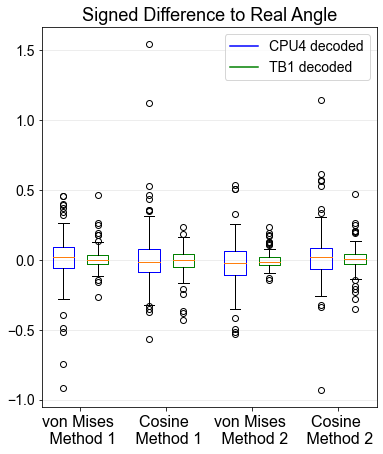

In [185]:
left_data = [make_angle(method1[:,0] - method1[:,2]), make_angle(method1[:,0] - method1[:,4])]
left_data += [make_angle(method2[:,0] - method2[:,2]), make_angle(method2[:,0] - method2[:,4])]


right_data = [make_angle(method1[:,0] - method1[:,1]), make_angle(method1[:,0] - method1[:,3])]
right_data += [make_angle(method2[:,0] - method2[:,1]), make_angle(method2[:,0] - method2[:,3])]

left_pos = [-0.4, 1.6, 3.6, 5.6]
right_pos = [0.4, 2.4, 4.4, 6.4]

plt.figure(figsize=(6,7))
b1 = plt.boxplot(left_data, positions=left_pos, notch=False)
b2 = plt.boxplot(right_data, positions=right_pos,notch=False)

# for box in bp1['boxes']:
#     box.set(color='blue', linewidth=5)
#     box.set(facecolor = 'red' )

[b.set_color('blue') for b in b1['boxes']]
[b.set_color('green') for b in b2['boxes']]

# , item.set_linewidth(4) for item in bp[key]['means']]
plt.xticks([0,2,4,6], ['von Mises \n Method 1', 'Cosine \n Method 1', 'von Mises \n Method 2', 'Cosine \n Method 2'], fontsize=16)
hB, = plot([1,1],'b-')
hR, = plot([1,1],'g-')
legend((hB, hR),('CPU4 decoded', 'TB1 decoded'))
hB.set_visible(False)
hR.set_visible(False)

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
plt.grid(True, linestyle='-', axis='y', which='major', color='lightgrey',
               alpha=0.5)

#plt.ylim([-0.75,0.75])
plt.title('Signed Difference to Real Angle', fontsize=18)
#plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/cpu4_signed_decoded.pdf'), bbox_inches = "tight")
plt.show()



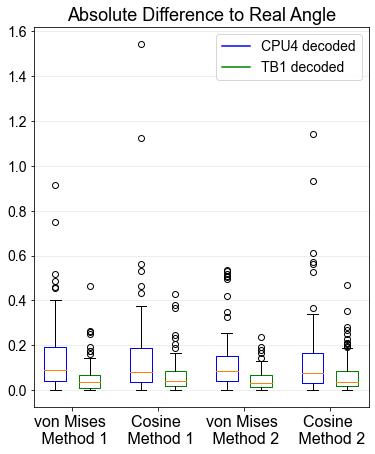

In [184]:
left_data = [np.abs(make_angle(method1[:,0] - method1[:,2])), np.abs(make_angle(method1[:,0] - method1[:,4]))]
left_data += [np.abs(make_angle(method2[:,0] - method2[:,2])), np.abs(make_angle(method2[:,0] - method2[:,4]))]


right_data = [np.abs(make_angle(method1[:,0] - method1[:,1])), np.abs(make_angle(method1[:,0] - method1[:,3]))]
right_data += [np.abs(make_angle(method2[:,0] - method2[:,1])), np.abs(make_angle(method2[:,0] - method2[:,3]))]

left_pos = [-0.4, 1.6, 3.6, 5.6]
right_pos = [0.4, 2.4, 4.4, 6.4]

plt.figure(figsize=(6,7))

b1 = plt.boxplot(left_data, positions=left_pos, notch=False)
b2 = plt.boxplot(right_data, positions=right_pos,notch=False)

# for box in bp1['boxes']:
#     box.set(color='blue', linewidth=5)
#     box.set(facecolor = 'red' )

[b.set_color('blue') for b in b1['boxes']]
[b.set_color('green') for b in b2['boxes']]

# , item.set_linewidth(4) for item in bp[key]['means']]
plt.xticks([0,2,4,6], ['von Mises \n Method 1', 'Cosine \n Method 1', 'von Mises \n Method 2', 'Cosine \n Method 2'], fontsize=16)
hB, = plot([1,1],'b-')
hR, = plot([1,1],'g-')
legend((hB, hR),('CPU4 decoded', 'TB1 decoded'))
hB.set_visible(False)
hR.set_visible(False)

# Add a horizontal grid to the plot, but make it very light in color
# so we can use it for reading data values but not be distracting
plt.grid(True, linestyle='-', axis='y', which='major', color='lightgrey',
               alpha=0.5)

# plt.ylim([0,1])
plt.title('Absolute Difference to Real Angle', fontsize=18)
# plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/cpu4_abs_decoded.pdf'), bbox_inches = "tight")
plt.show()



In [189]:
distances_m1 = distances[0,:,:]
distances_m2 = distances[1,:,:]

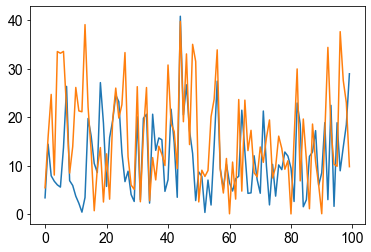

In [194]:
plt.plot(np.abs(distances_m1[:,1] - distances_m1[:,2]))
plt.plot(np.abs(distances_m2[:,1] - distances_m2[:,2]))

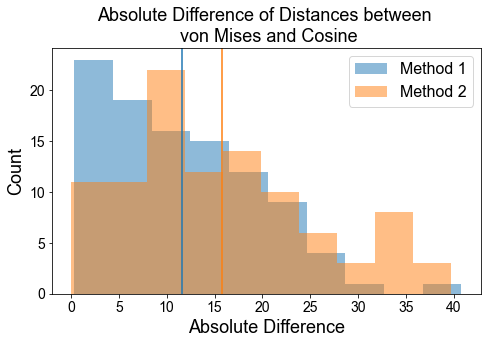

In [210]:

m1 = np.abs(distances_m1[:,1] - distances_m1[:,2])
m2 = np.abs(distances_m2[:,1] - distances_m2[:,2])
plt.figure(figsize=(7,5))
plt.hist(m1, label='Method 1', alpha=0.5, color='tab:blue')
plt.hist(m2, label='Method 2', alpha=0.5, color='tab:orange')
plt.axvline(np.mean(m1), color='tab:blue')
plt.axvline(np.mean(m2),  color='tab:orange')
plt.xlabel('Absolute Difference', fontsize=18)
plt.ylabel('Count', fontsize=18)
plt.legend(fontsize=16)
plt.title('Absolute Difference of Distances between \n von Mises and Cosine', fontsize=18)
plt.tight_layout()
plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/dissertation_plots/cpu4_decoded_distance_diff.pdf'),
              bbox_inches='tight')


plt.show()



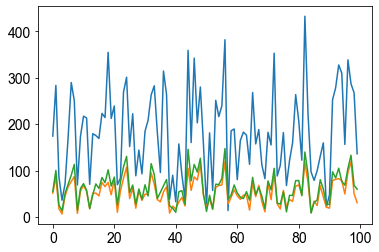

In [200]:
plt.plot(distances_m1[:,0])
plt.plot(distances_m1[:,1])
plt.plot(distances_m1[:,2])

In [206]:
print('method1')
print('vm', scipy.stats.pearsonr(distances_m1[:,0], distances_m1[:,1]))
print('cos', scipy.stats.pearsonr(distances_m1[:,0], distances_m1[:,2]))

print('method2')
print('vm', scipy.stats.pearsonr(distances_m2[:,0], distances_m2[:,1]))
print('cos', scipy.stats.pearsonr(distances_m2[:,0], distances_m2[:,2]))

method1
vm (0.8813117643533476, 1.1308461544158706e-33)
cos (0.8788584672170539, 2.898670953186632e-33)
method2
vm (0.9185156466576146, 2.813651731852734e-41)
cos (0.910295410328686, 2.5526294795271884e-39)


In [221]:
with open(os.path.join(routes_path, f'route_0.pickle'), 'rb') as fh:
    data = pickle.load(fh)

h = data['h']
v = data['v']
cx_log = data['cx_log']

with open(os.path.join(experiments_path, f'exp_0_cpu4_1.pickle'), 'rb') as fh:
    data = pickle.load(fh)

spiking_cx_vm_m1 = data['spiking_cx_vm']
spiking_cx_cos_m1 = data['spiking_cx_cos']

with open(os.path.join(experiments_path, f'exp_0_cpu4_2.pickle'), 'rb') as fh:
    data = pickle.load(fh)

spiking_cx_vm_m2 = data['spiking_cx_vm']
spiking_cx_cos_m2 = data['spiking_cx_cos']




In [227]:
def local_plot_memory_outbound(spiking_cx, cx_log, name, title=None, T_outbound=1500, figsize=(8,4)):
    plt.figure(figsize=figsize)
    plt.plot(spiking_cx['CPU4_memory_history'][T_outbound-1], label='CPU4')
    plt.plot(cx_log.memory[:,T_outbound-1] * spiking_cx['CPU4_memory_history'][T_outbound-1].max(), label='Stone (rescaled)')
    plt.legend()
    plt.xlabel('Neuron index')
    plt.xticks(np.arange(0, 16), np.arange(1, 16+1))
    plt.ylabel('impulses/s')
#     if title:
#         plt.title(title)
#     else:
#         plt.title('CPU4 accumulation - End of outbound')
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/cpu4_memory_example/{name}.pdf'),
                 bbox_inches='tight')
    plt.show()

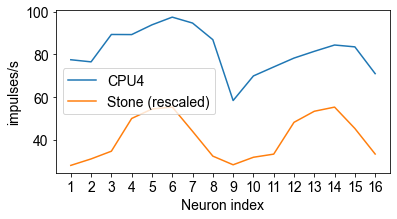

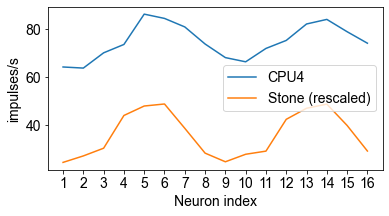

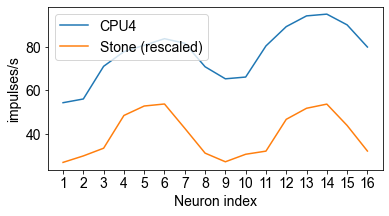

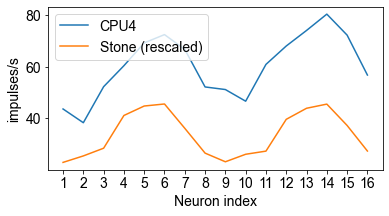

In [228]:
local_plot_memory_outbound(spiking_cx_vm_m1, cx_log, 'cpu4_memory_snapshot_vm_m1', 
                           title='von Mises - Method 1 \n CPU4 accumulation - End of outbound', figsize=(6,3))

local_plot_memory_outbound(spiking_cx_cos_m1, cx_log, 'cpu4_memory_snapshot_cos_m1', 
                           title='Cosine - Method 1 \n CPU4 accumulation - End of outbound', figsize=(6,3))

local_plot_memory_outbound(spiking_cx_vm_m2, cx_log, 'cpu4_memory_snapshot_vm_m2', 
                           title='von Mises - Method 2 \n CPU4 accumulation - End of outbound', figsize=(6,3))

local_plot_memory_outbound(spiking_cx_cos_m2, cx_log, 'cpu4_memory_snapshot_cos_m2', 
                           title='Cosine - Method 2 \n CPU4 accumulation - End of outbound', figsize=(6,3))

In [254]:
def plot_memory_outbound_accumulation(spiking_cx, cx_log, step=1500, name='', figsize=(15,5), savefig_=False):
    cmap = matplotlib.cm.get_cmap('tab10')
    plt.figure(figsize=figsize)
    ranges = range(spiking_cx['CPU4_memory_history'].shape[1]//2)
    for r in ranges:
        plt.plot(spiking_cx['CPU4_memory_history'][:step, r], alpha=0.6, 
                 label=r+1, color=cmap.colors[r])#, label=names[idx])
        plt.plot(cx_log.memory[r,:step]*100, ls='--', alpha=0.6, color=cmap.colors[r])
#     plt.legend(bbox_to_anchor=(1.09, 1), title='Neuron index')
    plt.legend(title='Neuron index', ncol=2)

    #plt.xlim([1400,1500])
    plt.title('CPU4 Accumulation Left Hemisphere - Outbound', fontsize=18)
    plt.xticks(np.arange(0, step+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=18-2)

    plt.ylabel('impulses/s', fontsize=18)
    plt.xlabel('Simulation steps', fontsize=18)
    
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/cpu4_memory_example/{name}_left.pdf'),
                 bbox_inches='tight')
    plt.show()

    plt.figure(figsize=figsize)
    ranges = range(spiking_cx['CPU4_memory_history'].shape[1]//2)
    for r in ranges:
        plt.plot(spiking_cx['CPU4_memory_history'][:step,r+8], alpha=0.6, label=r+1+8)#, label=names[idx])
        plt.plot(cx_log.memory[r+8,:step]*100, ls='--', alpha=0.6, color=cmap.colors[r])

#     plt.legend(bbox_to_anchor=(1.09, 1), title='Neuron index')
    plt.legend(title='Neuron index', ncol=2)
    #plt.xlim([1400,1500])
    plt.title('CPU4 Accumulation Right Hemisphere - Outbound', fontsize=18)
    plt.xticks(np.arange(0, step+1, 100) + 0.5, [1,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500], fontsize=18-2)


    plt.ylabel('impulses/s', fontsize=18)
    plt.xlabel('Simulation steps', fontsize=18)
    plt.savefig(os.path.join(os.environ.get('MSC_PROJECT'), f'notebooks/dissertation_plots/cpu4_memory_example/{name}_right.pdf'),
                 bbox_inches='tight')


    plt.show()

# plot_memory_outbound_accumulation(spiking_cx, cx_log, figsize=(15,5), savefig_=True)

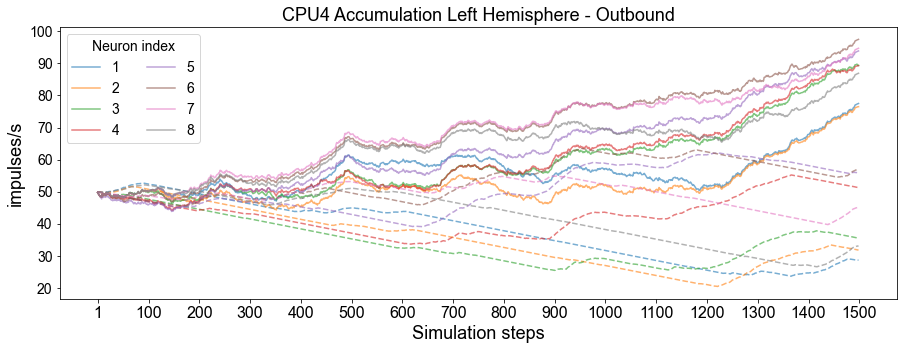

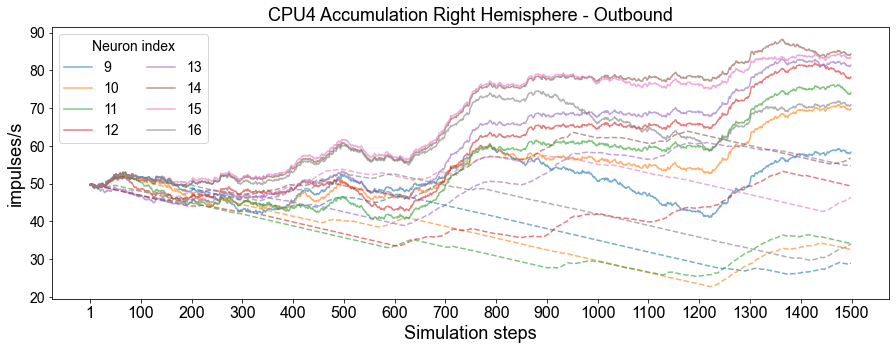

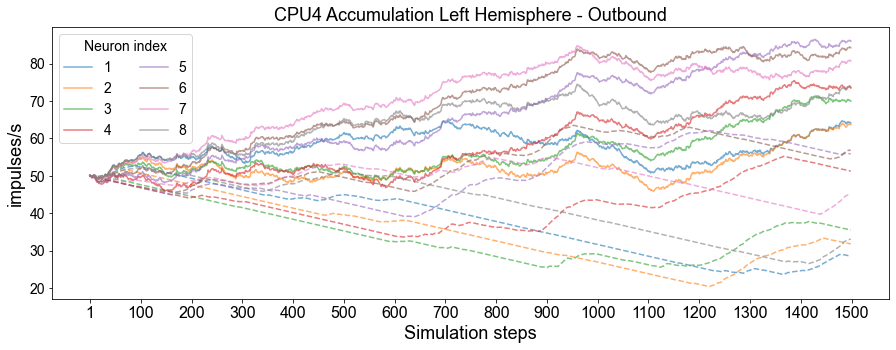

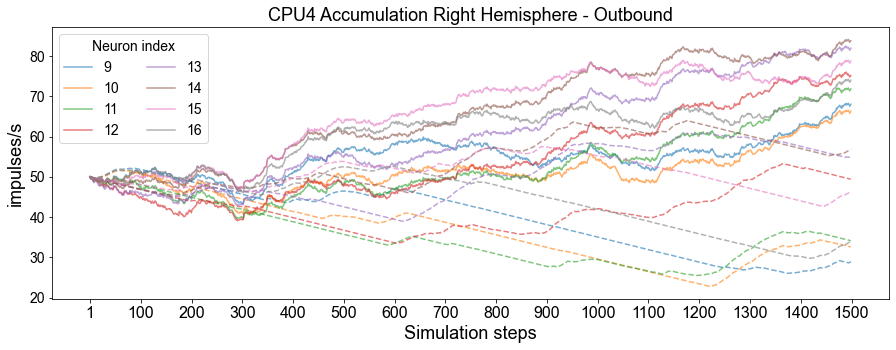

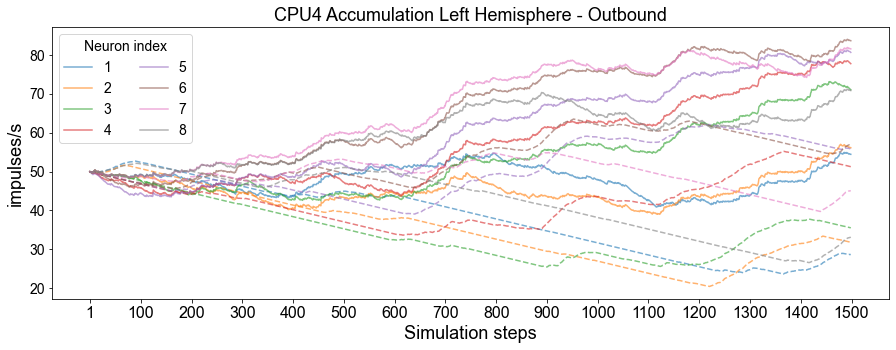

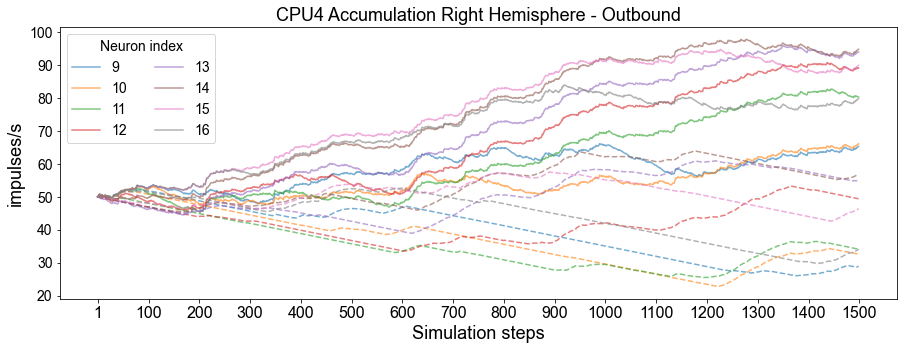

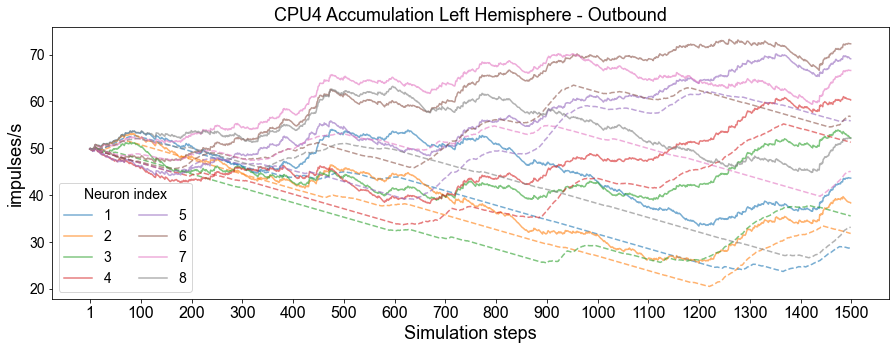

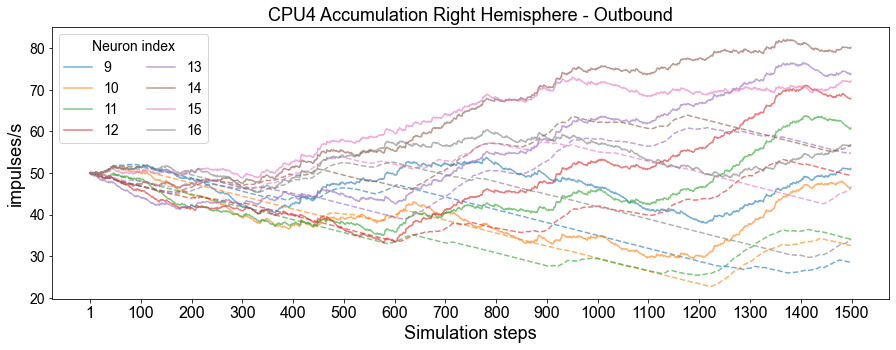

In [255]:
plot_memory_outbound_accumulation(spiking_cx_vm_m1, cx_log, name='vm_m1')

plot_memory_outbound_accumulation(spiking_cx_cos_m1, cx_log, name='cos_m1')

plot_memory_outbound_accumulation(spiking_cx_vm_m2, cx_log, name='vm_m2')

plot_memory_outbound_accumulation(spiking_cx_cos_m2, cx_log, name='cos_m2')